In [1]:
from pathlib import Path

In [2]:
input_path = Path("input")
output_path = Path("output")

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

for dirname, _, filenames in os.walk(input_path):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

input/test_data.csv
input/train_data.csv
input/sample_solution.csv


In [4]:
# %load_ext nb_black

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split


# %matplotlib ipympl

In [6]:
train = pd.read_csv(input_path / "train_data.csv")
test = pd.read_csv(input_path / "test_data.csv")

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 375734 entries, 0 to 375733
Columns: 246 entries, index to wind-vwnd-925-2010-20
dtypes: float64(240), int64(4), object(2)
memory usage: 705.2+ MB


In [8]:
train.describe().style.background_gradient(cmap="Pastel1")

In [9]:
train["startdate"]

0          9/1/14
1          9/2/14
2          9/3/14
3          9/4/14
4          9/5/14
           ...   
375729    8/27/16
375730    8/28/16
375731    8/29/16
375732    8/30/16
375733    8/31/16
Name: startdate, Length: 375734, dtype: object

In [10]:
pd.to_datetime(train["startdate"], infer_datetime_format=True)

0        2014-09-01
1        2014-09-02
2        2014-09-03
3        2014-09-04
4        2014-09-05
            ...    
375729   2016-08-27
375730   2016-08-28
375731   2016-08-29
375732   2016-08-30
375733   2016-08-31
Name: startdate, Length: 375734, dtype: datetime64[ns]

In [11]:
train["startdate"] = pd.to_datetime(train["startdate"], infer_datetime_format=True)
test["startdate"] = pd.to_datetime(test["startdate"], infer_datetime_format=True)

In [12]:
idx_sorted = train["startdate"].sort_values().index

<Figure size 640x480 with 0 Axes>

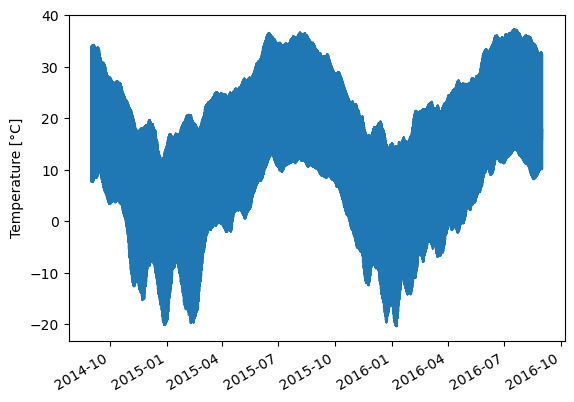

In [13]:
fig = plt.figure(1)
fig, ax = plt.subplots()
plt.plot(train["startdate"][idx_sorted], train["contest-tmp2m-14d__tmp2m"][idx_sorted])
# plt.plot(train["contest-tmp2m-14d__tmp2m"][idx_sorted])
ax.set_ylabel("Temperature [°C]")
fig.autofmt_xdate()
plt.show()

In [14]:
X = train.drop(
    ["contest-tmp2m-14d__tmp2m", "startdate", "climateregions__climateregion"], axis=1
)
y = train["contest-tmp2m-14d__tmp2m"]

In [15]:
# from xgboost import XGBRegressor
# from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# # create model instance
# model = XGBRegressor()
# # fit model
# model.fit(X_train, y_train)
# # make predictions
# preds = model.predict(X_test)
# preds

array([15.835684,  7.280448, 17.75564 , ..., 19.446638, 25.14084 ,
       15.487994], dtype=float32)

In [16]:
# # make a prediction
# yhat = model.predict(test.drop(["startdate", "climateregions__climateregion"], axis=1))
# # summarize prediction
# yhat

array([27.806349 , 27.840553 , 28.080185 , ...,  1.7293797,  1.7242367,
        3.1089375], dtype=float32)

In [22]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from xgboost import XGBRegressor

# define model
model = XGBRegressor()
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=2)
# force scores to be positive
scores = np.absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean MAE: 0.561 (0.004)


In [23]:
from sklearn.model_selection import cross_val_predict
# make a prediction
# yhat = model.predict(test.drop(["startdate", "climateregions__climateregion"], axis=1))
yhat = cross_val_predict(model, X, y, cv=cv)
# summarize prediction
yhat

ValueError: cross_val_predict only works for partitions

In [19]:
yhat_df = pd.DataFrame(yhat, test["index"])
yhat_df

0
index            
375734  27.806349
375735  27.840553
375736  28.080185
375737  28.601181
375738  28.508692
...           ...
407083   3.841964
407084   3.454024
407085   1.729380
407086   1.724237
407087   3.108938

[31354 rows x 1 columns]

In [21]:
yhat_df.to_csv(output_path / "res.csv", header=["contest-tmp2m-14d__tmp2m"], index_label="index")